In [1]:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt

In [3]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [14]:
def cv2_imshow(im):
  plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB));
  plt.show();

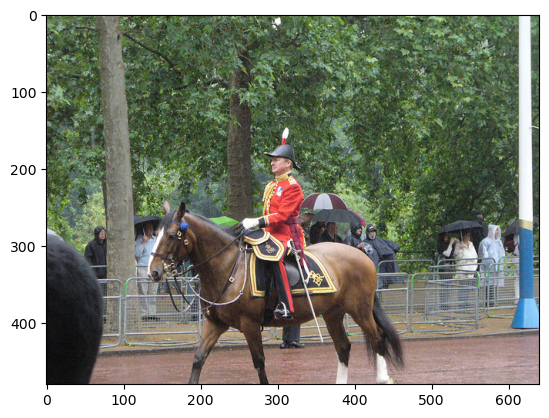

In [6]:
from matplotlib import pyplot as plt
im = cv2.imread("./input.jpg")
cv2_imshow(im)

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[07/24 12:12:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/home/ecervera/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.5981, 244.9053, 459.8281, 480.0000],
        [251.1066, 157.8138, 338.9735, 413.6304],
        [114.8493, 268.6837, 148.2368, 398.8164],
        [  0.8235, 281.0363,  78.6034, 478.4251],
        [ 49.3944, 274.1240,  80.1549, 342.9856],
        [561.2255, 271.5814, 596.2770, 385.2578],
        [385.9054, 270.3105, 413.7137, 304.0403],
        [515.9216, 278.3720, 562.2812, 389.3843],
        [335.2353, 251.9168, 414.7479, 275.9338],
        [350.9256, 269.2101, 386.0965, 297.9081],
        [331.6266, 231.0004, 393.2763, 257.2010],
        [510.7280, 263.2697, 570.9888, 295.9402],
        [409.0904, 271.8657, 460.5608, 356.8726],
        [506.8878, 283.3310, 529.9482, 324.0241],
        [594.5664, 283.4797, 609.0569, 311.4127]], device='cuda:0'))


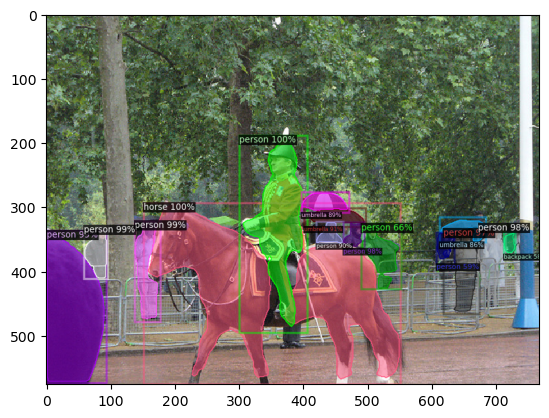

In [9]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("sps_dataset_train", {}, 
                        "/home/ecervera/Desktop/CERN/detectron2/jupyter-demo/annotations_contours/instances_Subset01.json", 
                        "/home/ecervera/Desktop/CERN/detectron2/jupyter-demo/image_SPS_1720795090")

In [11]:
sps_metadata = MetadataCatalog.get("sps_dataset_train")
sps_dataset = DatasetCatalog.get("sps_dataset_train")

[07/24 12:13:59 d2.data.datasets.coco]: Loaded 302 images in COCO format from /home/ecervera/Desktop/CERN/detectron2/jupyter-demo/annotations_contours/instances_Subset01.json


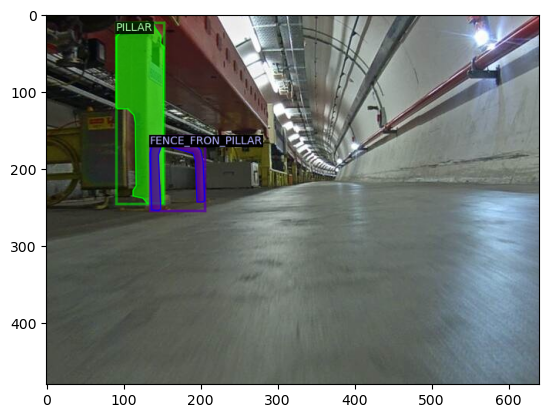

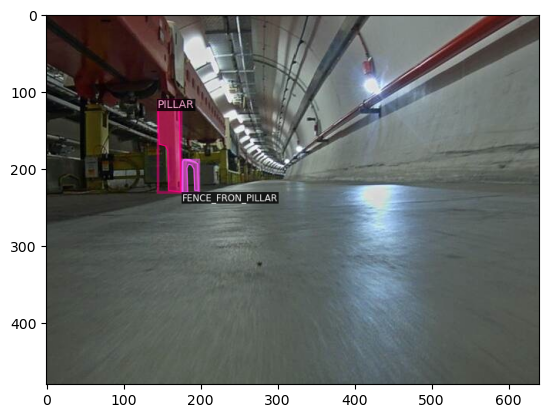

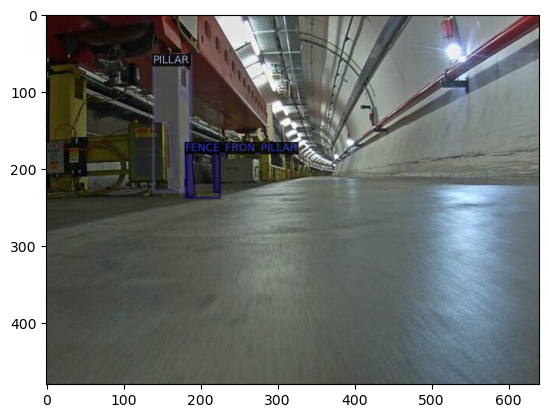

In [15]:
for d in random.sample(sps_dataset[:50], 3):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=sps_metadata)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

In [16]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sps_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonl
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300	# 300 iterations seems good enough 
cfg.SOLVER.STEPS = []    	# do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/24 12:15:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[07/24 12:15:50 d2.engine.train_loop]: Starting training from iteration 0
[07/24 12:15:54 d2.utils.events]:  eta: 0:00:56  iter: 19  total_loss: 2.332  loss_cls: 1.115  loss_box_reg: 0.4542  loss_mask: 0.6937  loss_rpn_cls: 0.05578  loss_rpn_loc: 0.01336    time: 0.1976  last_time: 0.1883  data_time: 0.0061  last_data_time: 0.0025   lr: 1.6068e-05  max_mem: 2419M
[07/24 12:15:58 d2.utils.events]:  eta: 0:00:51  iter: 39  total_loss: 2.072  loss_cls: 0.8621  loss_box_reg: 0.4525  loss_mask: 0.6865  loss_rpn_cls: 0.04385  loss_rpn_loc: 0.01088    time: 0.1954  last_time: 0.2139  data_time: 0.0022  last_data_time: 0.0026   lr: 3.2718e-05  max_mem: 2420M
[07/24 12:16:02 d2.utils.events]:  eta: 0:00:46  iter: 59  total_loss: 1.919  loss_cls: 0.6018  loss_box_reg: 0.5621  loss_mask: 0.6681  loss_rpn_cls: 0.02264  loss_rpn_loc: 0.008417    time: 0.1942  last_time: 0.2078  data_time: 0.0025  last_data_time: 0.0026   lr: 4.9367e-05  max_mem: 2420M
[07/24 12:16:06 d2.utils.events]:  eta: 0:00:41

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[07/24 12:17:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [18]:
from detectron2.utils.visualizer import ColorMode

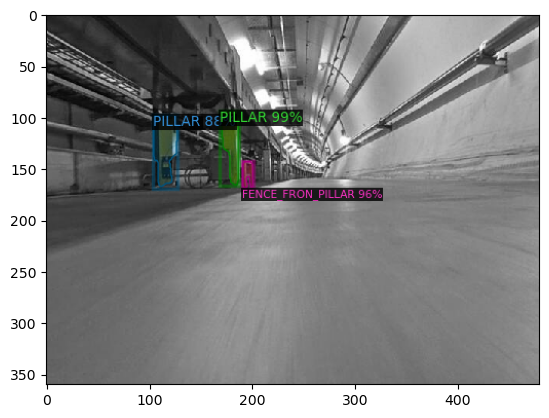

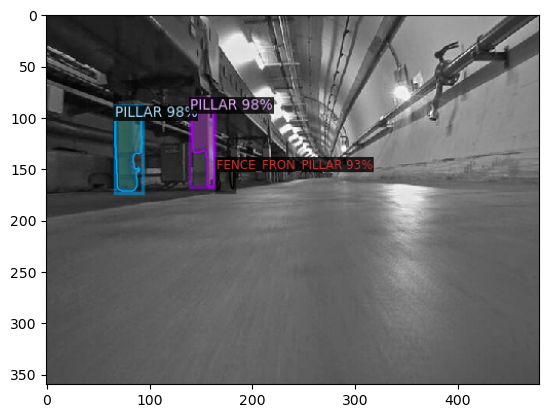

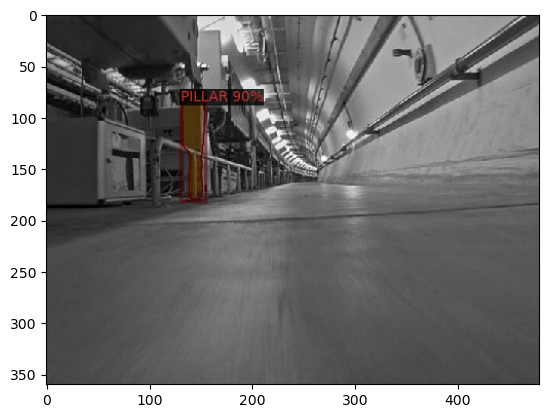

In [19]:
for d in random.sample(sps_dataset[51:], 3):
      im = cv2.imread(d["file_name"])
      outputs = predictor(im)
      v = Visualizer(im[:, :, ::-1],
               	metadata=sps_metadata,
               	scale=0.75,
               	instance_mode=ColorMode.IMAGE_BW
      )
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      cv2_imshow(out.get_image()[:, :, ::-1])